# Warpy: Farcaster datasets, one API call away.

Welcome to Warpy! This notebook will walk you through the basics.


In [ ]:
%pip install pandas
%pip install requests
%pip install tabulate
%pip install seaborn

In [13]:
import requests
import json
import pandas as pd
from tabulate import tabulate


def query_db(query: str, query_type: str = "english", export_csv: bool = False):
    url = "https://api.warpy.dev/query"
    headers = {"Content-Type": "application/json"}
    data = json.dumps(
        {"query": query, "type": query_type, "export": "csv" if export_csv else None}
    )
    response = requests.post(url, data=data, headers=headers)

    if response.status_code != 200:
        raise Exception(f"Request failed with status code {response.status_code}")

    return response.json()


def truncate_text(text, max_length=50):
    return text if len(text) <= max_length else text[:max_length] + "..."

In [2]:
# normal sql query, nothin' fancy
query = "SELECT fid, username, bio_text FROM users ORDER BY RAND() LIMIT 3;"

data = query_db(query, query_type="raw")
df = pd.DataFrame(data["result"])
df = df.applymap(lambda x: truncate_text(x) if isinstance(x, str) else x)
print(tabulate(df, headers="keys", tablefmt="outline"))

+----+-------+------------+-------------------------------------------------------+
|    |   fid | username   | bio_text                                              |
+====+=======+============+=======================================================+
|  0 |  3265 | tarrence   |                                                       |
|  1 |  4177 | xo         | Web 3 hater today, Web 3 lover tomorrow               |
|  2 |   407 | alfred     | building supertrue.com - https://tinyurl.com/super... |
+----+-------+------------+-------------------------------------------------------+


In [6]:
# use GPT-4 to write sql queries using the "english-advanced" type
# note: type: "english" is GPT-3.5 with simpler prompt, it's faster but less accurate;
# "english-advanced" is GPT-4 with more complex prompt, use this if you want to do
# complex joins, subqueries, etc.

query = (
    "get users who like the most liked cast, but only return the user with username"
    " that starts with 'b', only select fid, username, display_name, limit 3"
)

data = query_db(query, query_type="english-advanced")
df = pd.DataFrame(data["result"])
df = df.applymap(lambda x: truncate_text(x) if isinstance(x, str) else x)
print(tabulate(df, headers="keys", tablefmt="outline"))

+----+-------+-----------------+-----------------+
|    |   fid | username        | display_name    |
+====+=======+=================+=================+
|  0 |   379 | blockchainbrett | BlockchainBrett |
|  1 |  5985 | brazen          | brazenburrito   |
|  2 |  2941 | brittenwolf     | Britten Wolf    |
+----+-------+-----------------+-----------------+


In [14]:
# you can also export csv directly from the API
query = "get ten random casts that starts with 'gm'"
export_csv = True

result = query_db(query, query_type="english", export_csv=export_csv)
print(json.dumps(result, indent=4))

{
    "result": "https://pub-3916d8c82abb435eb70175747fdc2119.r2.dev/1682757135098.csv",
    "sql": "SELECT * FROM casts WHERE text LIKE 'gm%' ORDER BY RAND() LIMIT 10;",
    "schema": "09e5d80a53a4"
}


In [8]:
# Step 1: Get all casts containing the keywords
query = "SELECT hash, text, author_fid FROM casts WHERE text LIKE '%gjelina%' OR text LIKE '%erewhon%'"
cast_data = query_db(query)
cast_df = pd.DataFrame(cast_data["result"])

# Step 2: Print random sample of the filtered casts
random_casts_df = cast_df.sample(5)
print("Random sample of casts containing 'gjelina' or 'erewhon':")
random_casts_df["text"] = random_casts_df["text"].str.replace("\n", " ")
print(tabulate(random_casts_df, headers="keys", tablefmt="outline"))

# Step 3: Group by users who have at least 5 mentions and print their info
user_counts = cast_df["author_fid"].value_counts()
fids_with_at_least_5_mentions = user_counts[user_counts >= 5].index

query = f"SELECT fid, username, bio_text FROM users WHERE fid IN {tuple(fids_with_at_least_5_mentions)}"
users_data = query_db(query)
users_df = pd.DataFrame(users_data["result"])
users_df = users_df.applymap(lambda x: truncate_text(x) if isinstance(x, str) else x)

print("Users with at least 5 casts that contain 'gjelina' or 'erewhon':")
print(tabulate(users_df, headers="keys", tablefmt="outline"))

Random sample of casts containing 'gjelina' or 'erewhon':
+-----+--------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|     | hash                                       | text                                                                                                                                                         |   author_fid |
+=====+============================================+==============================================================================================================================================================+==============+
| 136 | 0x74076cd6328ade80da27487ff951e91873a64b32 | “Look I forgot what I was going to say because @nonlinear almost got us kicked out of the App Store again, but since you’re in town go check out Gjelina”    |          617 |
| 107 | 0xa7a7bc391d6ca823984fd291

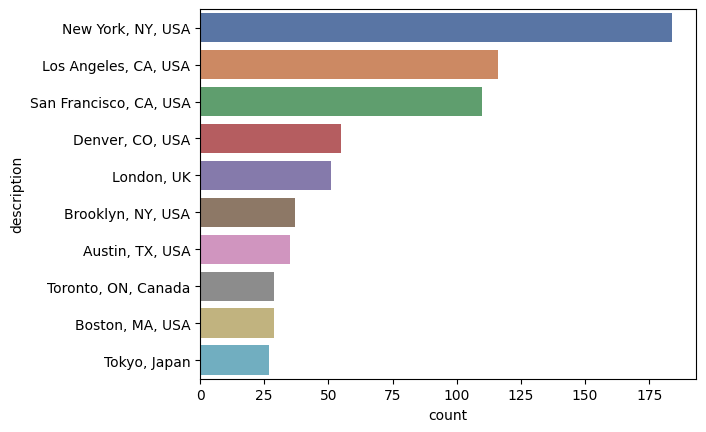

In [7]:
# you can use seaborn/matplotlib to visualize things
# ex: plot top 10 farcasters' most frequent locations
import seaborn as sns
import matplotlib.pyplot as plt

# get top 10 farcasters' most frequent locations
query = """
SELECT l.description, COUNT(*) AS count
FROM users u
JOIN locations l ON u.location_id = l.id
GROUP BY l.description
ORDER BY count DESC
LIMIT 10;
"""

data = query_db(query)
df = pd.DataFrame(data["result"])

sns.barplot(x='count', y='description', data=df, palette="deep")
plt.show()



Shoutout to Purple DAO for sponsoring Warpy! Check them out: https://purple.construction.

Complaints, comments, feedback to go @pixel on Farcaster. DM's open: t.me/pixelhackxyz :)
